#### Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim
import torch.utils.data as Data
from torchvision import transforms, models
#from skimage import io
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

C:\ProgramData\Anaconda3\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.15) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


#### Loading data and image paths

In [ ]:
# img_path = '/content/drive/MyDrive/plant-pathology-2020-fgvc7/images'
img_path =  'C:\\Users\\paris\\Desktop\\Studies\\skillSlash\\Computer Vision\\plant-pathology-2020-fgvc7\\images'
train = pd.read_csv('C:\\Users\\paris\\Desktop\\Studies\\skillSlash\\Computer Vision\\plant-pathology-2020-fgvc7\\train.csv')
test = pd.read_csv('C:\\Users\\paris\\Desktop\\Studies\\skillSlash\\Computer Vision\\plant-pathology-2020-fgvc7\\test.csv')

In [ ]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


#### Creating paths for all available images and labels

In [ ]:
train['image_path'] = img_path + '/' + train['image_id']+'.jpg'
test['image_path'] = img_path + '/' + test['image_id']+ '.jpg'
train_labels = train.loc[:, 'healthy':'scab']
train_paths = train.image_path
test_paths = test.image_path

In [ ]:
train_paths[0]

'C:\\Users\\paris\\Desktop\\Studies\\skillSlash\\Computer Vision\\plant-pathology-2020-fgvc7\\images/Train_0.jpg'

In [ ]:
data_labels = train.iloc[:, 1:].values
# Need for the StratifiedKFold split
data_labels2 = data_labels[:, 1] + data_labels[:,2] * 2 + data_labels[:,3] * 3
data_labels2[:10]

array([3, 1, 0, 2, 0, 0, 1, 3, 3, 0], dtype=object)

In [ ]:
classes = ['healthy', 'multiple_disease', 'rust', 'scab']

#### Creating class for loading image data

In [ ]:
class LeafDataset(Data.Dataset):
    def __init__(self, image_paths,labels):
        self.paths = image_paths
        self.labels = labels
    def __len__(self):
        return self.paths.shape[0]

    def __getitem__(self, i):
        image = mpimg.imread(self.paths[i])
        label = torch.tensor(np.argmax(self.labels.loc[i,:].values))

        return (image,label)

#### Creating train loader

In [ ]:
BATCH_SIZE=20
train_dataset = LeafDataset(train_paths, train_labels)
trainloader = Data.DataLoader(train_dataset, shuffle=True, batch_size = BATCH_SIZE, num_workers = 0)

#### Visualizing images from tarinloader

C:\Users\paris\AppData\Roaming\Python\Python38\site-packages\torch\utils\data\_utils\collate.py:149: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_numpy.cpp:178.)
  return default_collate([torch.as_tensor(b) for b in batch])


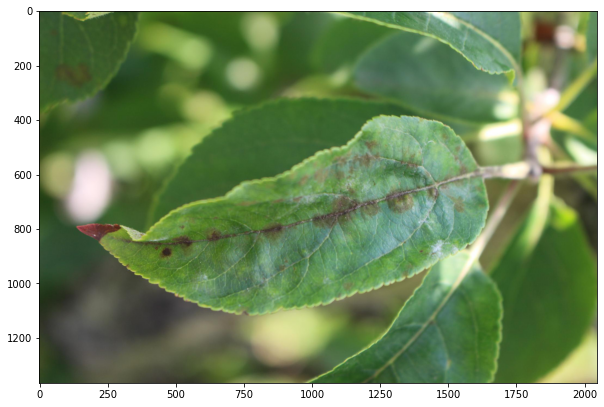

In [ ]:
# obtain one batch of training images
dataiter = iter(trainloader)
images,labels = dataiter.next()
plt.figure(figsize=(10,10))
plt.imshow(images[0])

In [ ]:
labels

tensor([3, 3, 3, 2, 1, 0, 2, 2, 3, 2, 2, 2, 2, 2, 2, 3, 3, 1, 2, 2])

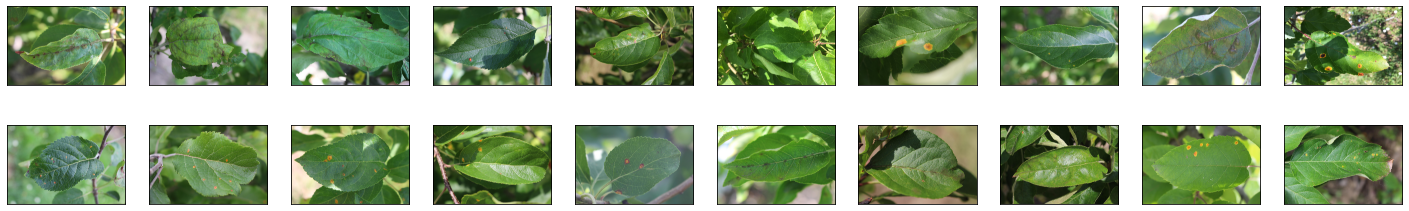

In [ ]:
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(images[idx])
    #ax.set_title(classes[labels[idx]])

#### Image Transformation aka Augmentation

###### Convert Image to Tensor <br>

Whenever we work with image data, it is always done by converting it into a NumpyArray

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
img = mpimg.imread(train_paths[0])
transformed_img = transform(img)
transformed_img.shape

torch.Size([3, 1365, 2048])

In [ ]:
images[0].shape

torch.Size([1365, 2048, 3])

###### Normalise image so that all values are between -1 and 1 or 0 and 1

In [ ]:
#torchvision.transforms.Normalize([meanOfChannel1, meanOfChannel2, meanOfChannel3],
                                 # [stdOfChannel1, stdOfChannel2, stdOfChannel3])
#Example:
transform = transforms.Compose([transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

transformed_img = transform(img)
transformed_img.shape

torch.Size([3, 1365, 2048])

In [ ]:
img = mpimg.imread(train_paths[0])
img

array([[[ 33,  51,  13],
        [ 33,  51,  13],
        [ 33,  51,  13],
        ...,
        [ 51,  61,  27],
        [ 51,  61,  27],
        [ 51,  61,  27]],

       [[ 33,  51,  13],
        [ 33,  51,  13],
        [ 33,  51,  13],
        ...,
        [ 50,  60,  26],
        [ 50,  60,  26],
        [ 50,  60,  26]],

       [[ 33,  51,  13],
        [ 33,  51,  13],
        [ 33,  51,  13],
        ...,
        [ 50,  60,  26],
        [ 50,  60,  26],
        [ 50,  60,  26]],

       ...,

       [[181, 167, 120],
        [182, 168, 121],
        [182, 168, 121],
        ...,
        [199, 206, 152],
        [197, 202, 148],
        [196, 201, 145]],

       [[181, 167, 120],
        [182, 168, 121],
        [182, 168, 121],
        ...,
        [200, 207, 155],
        [200, 204, 153],
        [202, 206, 155]],

       [[181, 167, 120],
        [182, 168, 121],
        [182, 168, 121],
        ...,
        [205, 213, 164],
        [206, 212, 164],
        [212, 215, 168]]

In [ ]:
transformed_img

tensor([[[-0.7412, -0.7412, -0.7412,  ..., -0.6000, -0.6000, -0.6000],
         [-0.7412, -0.7412, -0.7412,  ..., -0.6078, -0.6078, -0.6078],
         [-0.7412, -0.7412, -0.7412,  ..., -0.6078, -0.6078, -0.6078],
         ...,
         [ 0.4196,  0.4275,  0.4275,  ...,  0.5608,  0.5451,  0.5373],
         [ 0.4196,  0.4275,  0.4275,  ...,  0.5686,  0.5686,  0.5843],
         [ 0.4196,  0.4275,  0.4275,  ...,  0.6078,  0.6157,  0.6627]],

        [[-0.6000, -0.6000, -0.6000,  ..., -0.5216, -0.5216, -0.5216],
         [-0.6000, -0.6000, -0.6000,  ..., -0.5294, -0.5294, -0.5294],
         [-0.6000, -0.6000, -0.6000,  ..., -0.5294, -0.5294, -0.5294],
         ...,
         [ 0.3098,  0.3176,  0.3176,  ...,  0.6157,  0.5843,  0.5765],
         [ 0.3098,  0.3176,  0.3176,  ...,  0.6235,  0.6000,  0.6157],
         [ 0.3098,  0.3176,  0.3176,  ...,  0.6706,  0.6627,  0.6863]],

        [[-0.8980, -0.8980, -0.8980,  ..., -0.7882, -0.7882, -0.7882],
         [-0.8980, -0.8980, -0.8980,  ..., -0

##### CenterCrop <br>
This will crop the given tensor image at the center. You can provide the size you want to crop as input <br> in the form of height and width

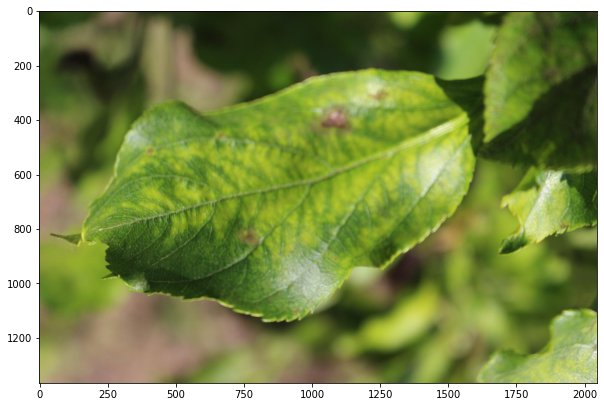

In [ ]:
img = mpimg.imread(train_paths[0])
plt.figure(figsize=(10,10))
plt.imshow(img)

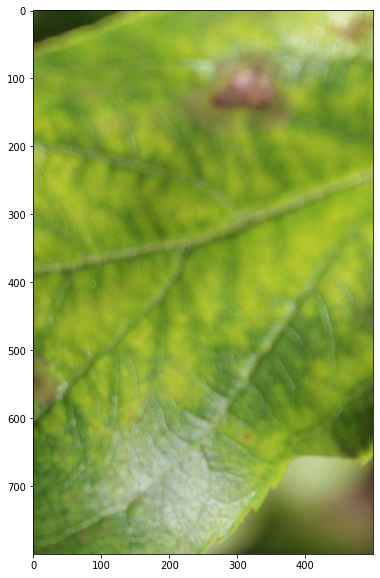

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),transforms.CenterCrop((800,500))])

transformed_img = transform(img)
transformed_img.shape
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(transformed_img, (1, 2, 0)))
#plt.imshow(transformed_img)

##### Random Horizonntal Flip

Randomly rotate image horizontally

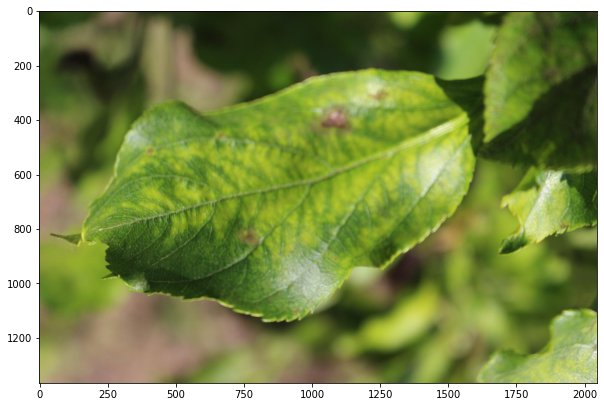

In [ ]:
img = mpimg.imread(train_paths[0])
plt.figure(figsize=(10,10))
plt.imshow(img)

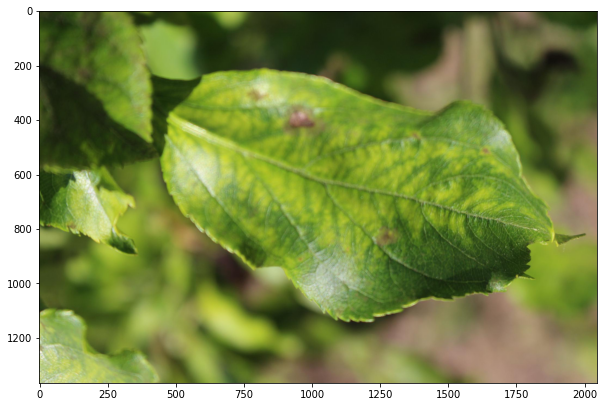

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),transforms.RandomHorizontalFlip(p=0.9)])

transformed_img = transform(img)
transformed_img.shape
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(transformed_img, (1, 2, 0)))
#plt.imshow(transformed_img)

##### RandomRotation
Rotate your image randomly by an angle

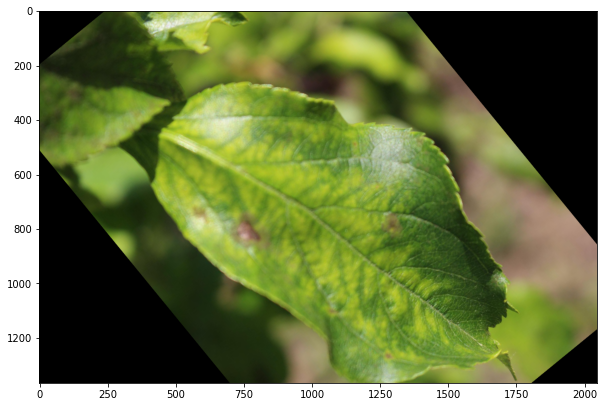

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),transforms.RandomRotation(degrees=180)])
transformed_img = transform(img)
transformed_img.shape
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(transformed_img, (1, 2, 0)))
#plt.imshow(transformed_img)

### Bringing All transforms together and recreating or data loader

In [ ]:
class data_loading_class(Data.Dataset):
    def __init__(self, image_paths,labels):
        self.paths = image_paths
        self.labels = labels
        self.data_transforms = transforms.Compose([transforms.ToTensor(),
                                                   transforms.Resize((512,512)),
                                                   #transforms#.Resize((256,256)),
                                                   transforms.RandomRotation(degrees=180),
                                                   transforms.RandomHorizontalFlip(p=0.5),
                                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    def __len__(self):
        return self.paths.shape[0]

    def __getitem__(self, i):
        image = mpimg.imread(self.paths[i])
        image = self.data_transforms(image)
        label = self.labels[i]

        return (image,label)

In [ ]:
BATCH_SIZE=20
combined_dataset = data_loading_class(train_paths, data_labels2)
comb_data_loader = Data.DataLoader(combined_dataset, shuffle=True, batch_size = BATCH_SIZE, num_workers = 0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


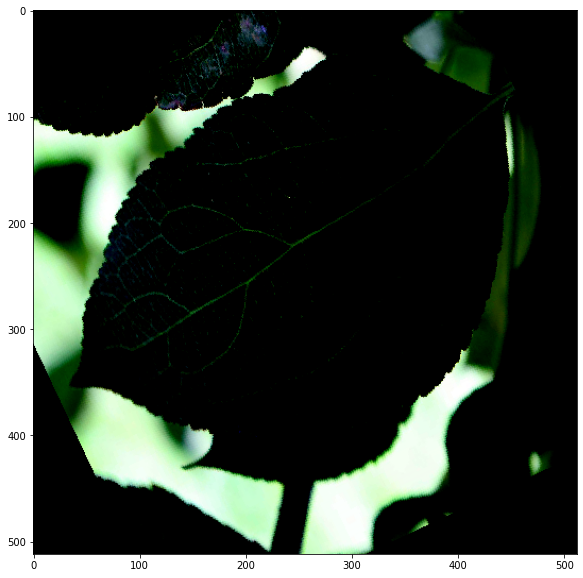

In [ ]:
# obtain one batch of training images
dataiter = iter(comb_data_loader)
images,labels = dataiter.next()
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(images[0], (1, 2, 0)))

In [ ]:
train_set, test_set = torch.utils.data.random_split(combined_dataset, [1457,364])
train_loader = Data.DataLoader(dataset = train_set,batch_size = BATCH_SIZE, shuffle = True)
test_loader = Data.DataLoader(dataset = test_set,batch_size = BATCH_SIZE, shuffle = True)

In [ ]:
# obtain one batch of training images
dataiter = iter(train_loader)
images,label = dataiter.next()
images[0].shape
# plt.figure(figsize=(10,10))
# plt.imshow(np.transpose(images[0], (1, 2, 0)))
len(labels)

20

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


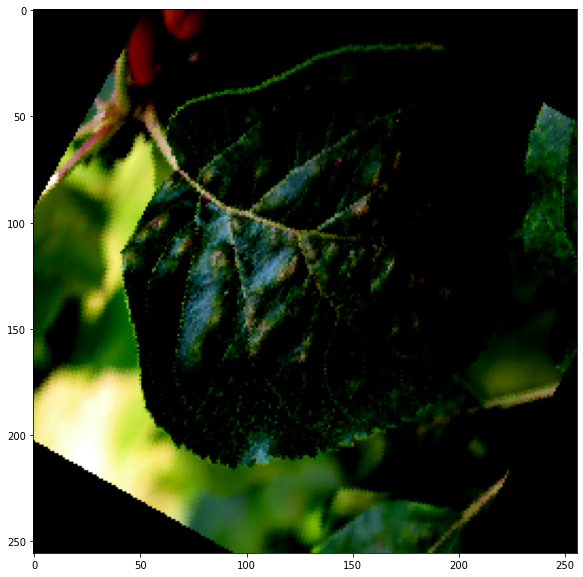

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images,labels = dataiter.next()
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(images[0], (1, 2, 0)))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        #We supply following inputs to the function
        #in_channels - Number of channels in the unput image
        #out_channels- Number of channels produced by the convolution
        #kernel_size - size of the filter
        #input size image : 256x256
#         self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
#         self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
#         self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        # convolutional layer (sees 4x4x64 tensor)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 32 * 32 -> 500)\

#         self.fc1 = nn.Linear(64 * 64 * 64, 500)
        self.fc1 = nn.Linear(256 * 32 * 32, 500)

        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 4)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        # X will go into the first convolution layer and produce 16 channel feature map
        # This feature map will be then passed through an activation function
        # Finally the feature map will pass through a 2x2 max pooling layer
        x = self.pool(F.relu(self.conv1(x)))
        #print("shape after cv1:", x.shape)
        # X will go into the first convolution layer and produce 32 channel image
        # This feature map will be then passed through an activation function
        # Finally the feature map will pass through a 2x2 max pooling layer
        x = self.pool(F.relu(self.conv2(x)))
        #print("shape after cv2:", x.shape)
        # X will go into the first convolution layer and produce 64 channel image
        # This feature map will be then passed through an activation function
        # Finally the feature map will pass through a 2x2 max pooling layer
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        #print("shape after all cv:", x.shape)
        # flatten image input
        x = x.view(-1,256 * 32 * 32)
        #print("shape after flatten:", x.shape)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        #print("shape after all l1:", x.shape)
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        #print("shape after all l2:", x.shape)
        return x

In [ ]:
# create a complete CNN
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=262144, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=4, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [ ]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
# number of epochs to train the model
n_epochs = 2
valid_loss_min = np.Inf # track change in validation loss
for epoch in range(1, n_epochs+1):
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # In this step we set the gradients as 0 so that they can be trained
        optimizer.zero_grad()
        '''Feed forward mechanism:
        This will send our batch of data through the network and
        # Calculate the probabilities for each image '''
        output = model(data)
        '''Once our data has been passed through the network, we get probabilities as an output
        This output is howvwer meaningless. Our model still needs to train. To understand
        where our model went worng we compute the loss.'''
        loss = criterion(output, target)
        '''Backward mechanism: Once our loss is calculated, its time to change the weights and
        optimise our network. This is the part where we back propogate our error through the network
        calculate the gradients at each point and change the weights accordingly'''
        loss.backward()
        '''The next optimizer step will allow us to change the magnitude of steps we take
        to reach the global minimum'''
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
    '''As our model is trained for the first batch, we test it immediately. This helps us understand
    if our model is actually improving with every iteration or not'''
    ######################
    # validate the model #
    ######################
    model.eval()
    for data, target in test_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss
        valid_loss += loss.item()*data.size(0)

    '''After the forward pass is done, the loss will be backpropogated through the network
    to update the weights and same process will be done for the number of epochs we will be using for training'''

    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(test_loader.sampler)

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

In [ ]:
# number of epochs to train the model
n_epochs = 2
valid_loss_min = np.Inf # track change in validation loss
for epoch in range(1, n_epochs+1):
    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # In this step we set the gradients as 0 so that they can be trained
        optimizer.zero_grad()
        '''Feed forward mechanism:
        This will send our batch of data through the network and
        # Calculate the probabilities for each image '''
        output = model(data)
        '''Once our data has been passed through the network, we get probabilities as an output
        This output is howvwer meaningless. Our model still needs to train. To understand
        where our model went worng we compute the loss.'''
        loss = criterion(output, target)
        '''Backward mechanism: Once our loss is calculated, its time to change the weights and
        optimise our network. This is the part where we back propogate our error through the network
        calculate the gradients at each point and change the weights accordingly'''
        loss.backward()
        '''The next optimizer step will allow us to change the magnitude of steps we take
        to reach the global minimum'''
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
    '''As our model is trained for the first batch, we test it immediately. This helps us understand
    if our model is actually improving with every iteration or not'''
    ######################
    # validate the model #
    ######################
    model.eval()
    for data, target in test_loader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss
        valid_loss += loss.item()*data.size(0)

    '''After the forward pass is done, the loss will be backpropogated through the network
    to update the weights and same process will be done for the number of epochs we will be using for training'''

    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(test_loader.sampler)

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

In [ ]:
model = Net()

In [ ]:
model.load_state_dict(torch.load('model_cifar.pt'))
model.eval()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=4, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

In [ ]:
image = images[1].unsqueeze(0)  # Add batch dimension
# [1,channels, height, width]

In [ ]:
#torch.no_grad()
with torch.no_grad():
    output = model(image)
    _, predicted = torch.max(output, 1)

In [ ]:
actual_label = labels[1]
print('Actual Label:', actual_label.item())

Actual Label: 3


In [ ]:
predicted

tensor([2])

In [ ]:
label

tensor([3, 2, 3, 2, 0, 2, 3, 3, 2, 2, 0, 2, 2, 3, 2, 2, 3, 0, 0, 2])